In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import colors
import matplotlib.animation as animation
from sympy import Symbol, sin, cos, sqrt, diff, lambdify, symbols
from sympy.physics.vector import *

### *Skip to next italicized text for just plotting*

## EM Field from Rest Frame of Synchrotron

A correction to the writeup:
$$r(\tau) = \rho\cos(\omega\tau)\mathbf{\hat{x}} + \rho\sin(\omega\tau)\mathbf{\hat{y}} + v_\|\tau\mathbf{\hat{z}}$$
where $\rho$ is the radius of the helical motion.

In [2]:
# Synchrotron conditions
q = 1  #charge
m = 1  #mass
beta = 0.9  #v/c
B_ext = 1  #extenal mag field
phi = np.pi/6  #angle between velocity and B

In [3]:
# Derived parameters
v_par = beta*cos(phi)  #parallel velocity to B
v_perp = beta*sin(phi)  #perpendicular velocity to B
gamma = 1/(sqrt(1-beta**2))
rho = (gamma*m*v_perp)/(q*B_ext)  # radius of helical motion
omega = (q*B_ext)/(gamma*m)  #angular frequency of synchrotron

In [4]:
# Initialize reference frame and variables in SymPy
S = ReferenceFrame('S')

t, x, y, z, tau = symbols(r't x y z \tau')
R = S[0]*S.x + S[1]*S.y + S[2]*S.z
R_mag = sqrt(R.dot(R))
n = R/R_mag

In [5]:
# Kinematics
r = rho*cos(omega*t)*S.x + rho*sin(omega*t)*S.y + v_perp*t*S.z
v = diff(r, t, frame=S)
a = diff(v, t, frame=S)

In [6]:
# Split into components for lambdify (wish there was an easier way)
rx = r.dot(S.x)
ry = r.dot(S.y)
rz = r.dot(S.z)

vx = v.dot(S.x)
vy = v.dot(S.y)
vz = v.dot(S.z)

ax = a.dot(S.x)
ay = a.dot(S.y)
az = a.dot(S.z)

In [7]:
# Lambdify to turn into NumPy functions
lam_rx = lambdify(t, rx, "numpy")
lam_ry = lambdify(t, ry, "numpy")
lam_rz = lambdify(t, rz, "numpy")

lam_vx = lambdify(t, vx, "numpy")
lam_vy = lambdify(t, vy, "numpy")
lam_vz = lambdify(t, vz, "numpy")

lam_ax = lambdify(t, ax, "numpy")
lam_ay = lambdify(t, ay, "numpy")
lam_az = lambdify(t, az, "numpy")

In [8]:
# Evaluate synchrotron motion at timesteps and save in array
nsteps = 201
timesteps = np.linspace(0, 100, nsteps)

r_x = np.array(lam_rx(timesteps)).astype(float)
r_y = np.array(lam_ry(timesteps)).astype(float)
r_z = np.array(lam_rz(timesteps)).astype(float)

v_x = np.array(lam_vx(timesteps)).astype(float)
v_y = np.array(lam_vy(timesteps)).astype(float)
v_z = np.array(lam_vz(timesteps)).astype(float)

a_x = np.array(lam_ax(timesteps)).astype(float)
a_y = np.array(lam_ay(timesteps)).astype(float)
a_z = np.array(lam_az(timesteps)).astype(float)

#### Figure showing motion of synchrotron from a still observer frame

<IPython.core.display.Javascript object>


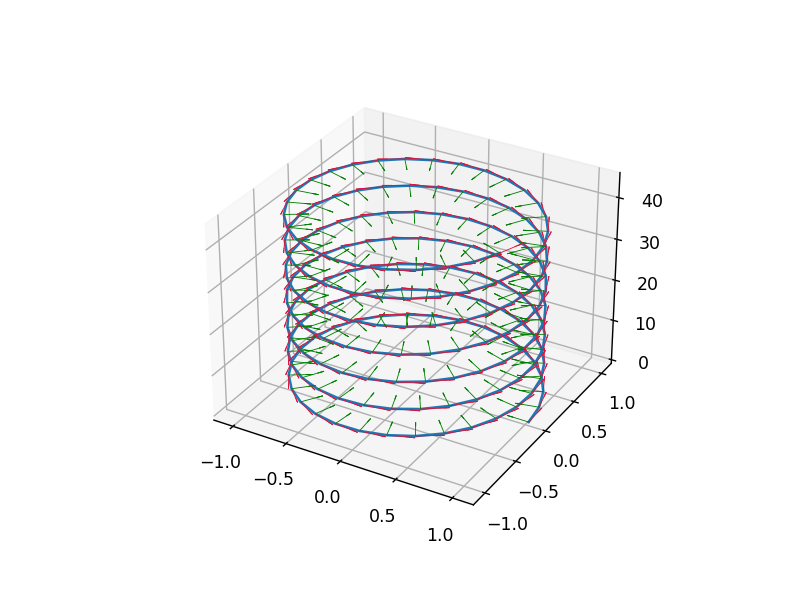

In [9]:
fig = plt.figure()
axis = plt.axes(projection='3d')
axis.plot3D(r_x, r_y, r_z)
axis.quiver(r_x, r_y, r_z, v_x, v_y, v_z, length=0.5, lw=0.5, color='crimson')
axis.quiver(r_x, r_y, r_z, a_x, a_y, a_z, length=1, lw=0.5, color='green')
plt.show()

#### Now on to EM fields
There are x, y, z components to both E and B fields at all points in space which is hard to visualize, so we will visualize each component on 2D slices at $z=0$ and $x=0$.
#### First for z = 0

In [10]:
# Calculate E and B fields according to writeup
E = q*((n-v)/(gamma**2*(1-n.dot(v))**3*R_mag**2)) + q*((n.cross((n-v).cross(a)))/((1-n.dot(v))**3*R_mag))
B = curl(E, S)

In [11]:
# Evaluate fields at z=0 to simplify expression
E0 = E.evalf(subs={S[2]: 0, S[0]: x, S[1]: y})
B0 = B.evalf(subs={S[2]: 0, S[0]: x, S[1]: y})

In [12]:
# Split into components
Ex = E0.dot(S.x)
Ey = E0.dot(S.y)
Ez = E0.dot(S.z)

Bx = B0.dot(S.x)
By = B0.dot(S.y)
Bz = B0.dot(S.z)

In [13]:
# Turn into NumPy functions
lam_Ex = lambdify([t, x, y], Ex, "numpy")
lam_Ey = lambdify([t, x, y], Ey, "numpy")
lam_Ez = lambdify([t, x, y], Ez, "numpy")

lam_Bx = lambdify([t, x, y], Bx, "numpy")
lam_By = lambdify([t, x, y], By, "numpy")
lam_Bz = lambdify([t, x, y], Bz, "numpy")

In [14]:
# Create list of timesteps and points in space
tau = np.linspace(0, 100, nsteps)
ngrids = 100
X, Y = np.meshgrid(np.linspace(-10, 10, ngrids), np.linspace(-10, 10, ngrids))

x_pts = X.flatten()
y_pts = Y.flatten()
rho_pts = np.sqrt(x_pts**2 + y_pts**2)

In [15]:
# Create data cubes to store slices at each timestep
E_x = np.ndarray((nsteps, ngrids, ngrids))
E_y = np.ndarray((nsteps, ngrids, ngrids))
E_z = np.ndarray((nsteps, ngrids, ngrids))

B_x = np.ndarray((nsteps, ngrids, ngrids))
B_y = np.ndarray((nsteps, ngrids, ngrids))
B_z = np.ndarray((nsteps, ngrids, ngrids))

In [20]:
# Evaluate for all points of the data cube
for i, grid in enumerate(E_z):
    
    E_x[i] = lam_Ex(tau[i]-rho_pts, x_pts, y_pts).reshape(ngrids, ngrids)
    E_y[i] = lam_Ey(tau[i]-rho_pts, x_pts, y_pts).reshape(ngrids, ngrids)
    E_z[i] = lam_Ez(tau[i]-rho_pts, x_pts, y_pts).reshape(ngrids, ngrids)
    
    B_x[i] = lam_Bx(tau[i]-rho_pts, x_pts, y_pts).reshape(ngrids, ngrids)
    B_y[i] = lam_By(tau[i]-rho_pts, x_pts, y_pts).reshape(ngrids, ngrids)
    B_z[i] = lam_Bz(tau[i]-rho_pts, x_pts, y_pts).reshape(ngrids, ngrids)

# Save files for easier access next time
np.save('E_x_xy.npy', E_x)
np.save('E_y_xy.npy', E_y)
np.save('E_z_xy.npy', E_z)
np.save('B_x_xy.npy', B_x)
np.save('B_y_xy.npy', B_y)
np.save('B_z_xy.npy', B_z)

### *Start at this cell for just plotting*

In [12]:
E_x = np.load('E_x_xy.npy')
E_y = np.load('E_y_xy.npy')
E_z = np.load('E_z_xy.npy')
B_x = np.load('B_x_xy.npy')
B_y = np.load('B_y_xy.npy')
B_z = np.load('B_z_xy.npy')

#### Plotting E field components for z = 0

MovieWriter ffmpeg unavailable; using Pillow instead.


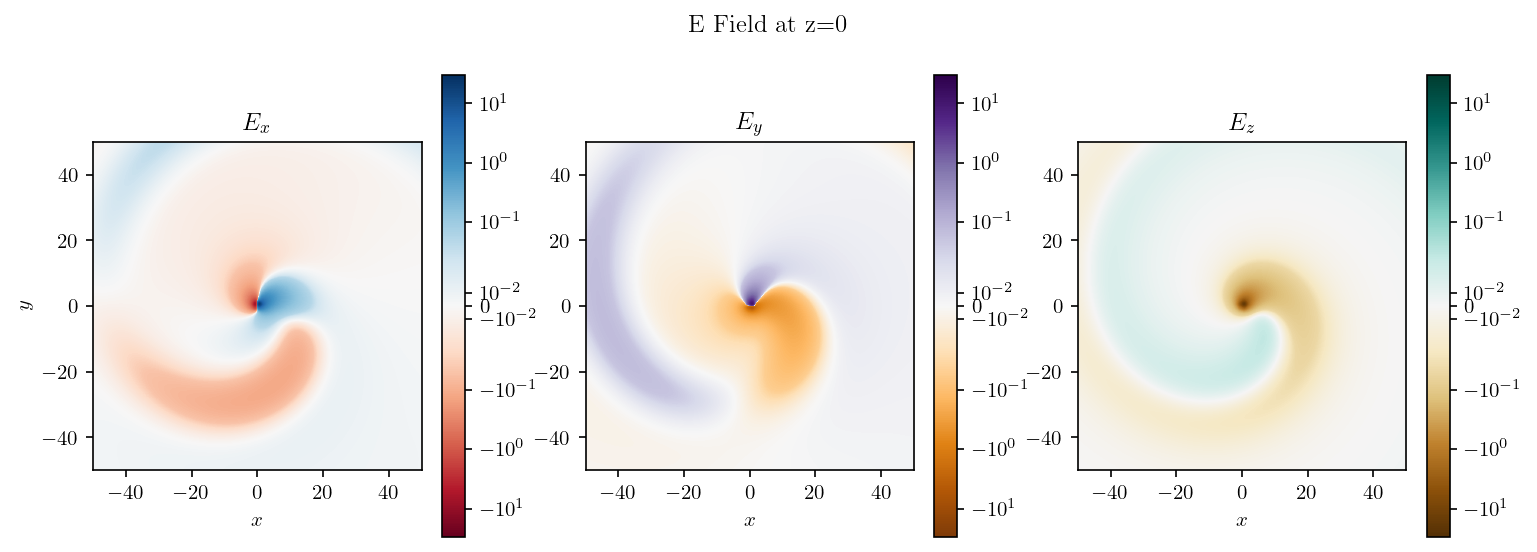

In [13]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 150})
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(4)
fig.suptitle('E Field at z=0')
normxy = colors.SymLogNorm(linthresh=5e-2, vmin=-30, vmax=30, base=10)
normz = colors.SymLogNorm(linthresh=5e-2, vmin=-30, vmax=30, base=10)
smx = plt.cm.ScalarMappable(cmap="RdBu", norm=normxy)
smy = plt.cm.ScalarMappable(cmap="PuOr", norm=normxy)
smz = plt.cm.ScalarMappable(cmap="BrBG", norm=normz)

im1 = ax[0].imshow(E_x[0], norm=normxy, interpolation='gaussian', origin='lower', cmap="RdBu",
                   extent=[-E_x[0].shape[1]/2., E_x[0].shape[1]/2., -E_x[0].shape[0]/2., E_x[0].shape[0]/2. ])
im2 = ax[1].imshow(E_y[0], norm=normxy, interpolation='gaussian', origin='lower', cmap="PuOr",
                   extent=[-E_y[0].shape[1]/2., E_y[0].shape[1]/2., -E_y[0].shape[0]/2., E_y[0].shape[0]/2. ])
im3 = ax[2].imshow(E_z[0], norm=normz, interpolation='gaussian', origin='lower', cmap="BrBG",
                   extent=[-E_z[0].shape[1]/2., E_z[0].shape[1]/2., -E_z[0].shape[0]/2., E_z[0].shape[0]/2. ])

fig.colorbar(smx, ax=ax[0])
fig.colorbar(smy, ax=ax[1])
fig.colorbar(smz, ax=ax[2])

ax[0].set_title(r'$E_x$')
ax[1].set_title(r'$E_y$')
ax[2].set_title(r'$E_z$')
ax[0].set_xlabel(r'$x$')
ax[1].set_xlabel(r'$x$')
ax[2].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')

def animate(i) :
    im1.set_data(E_x[i])
    im2.set_data(E_y[i])
    im3.set_data(E_z[i])
    
ani = animation.FuncAnimation(fig, animate, 200, interval=50, repeat=True)
ani.save('synchrotron_rest_frame_E_xy.gif')

plt.show()

#### B field components for z = 0

<IPython.core.display.Javascript object>


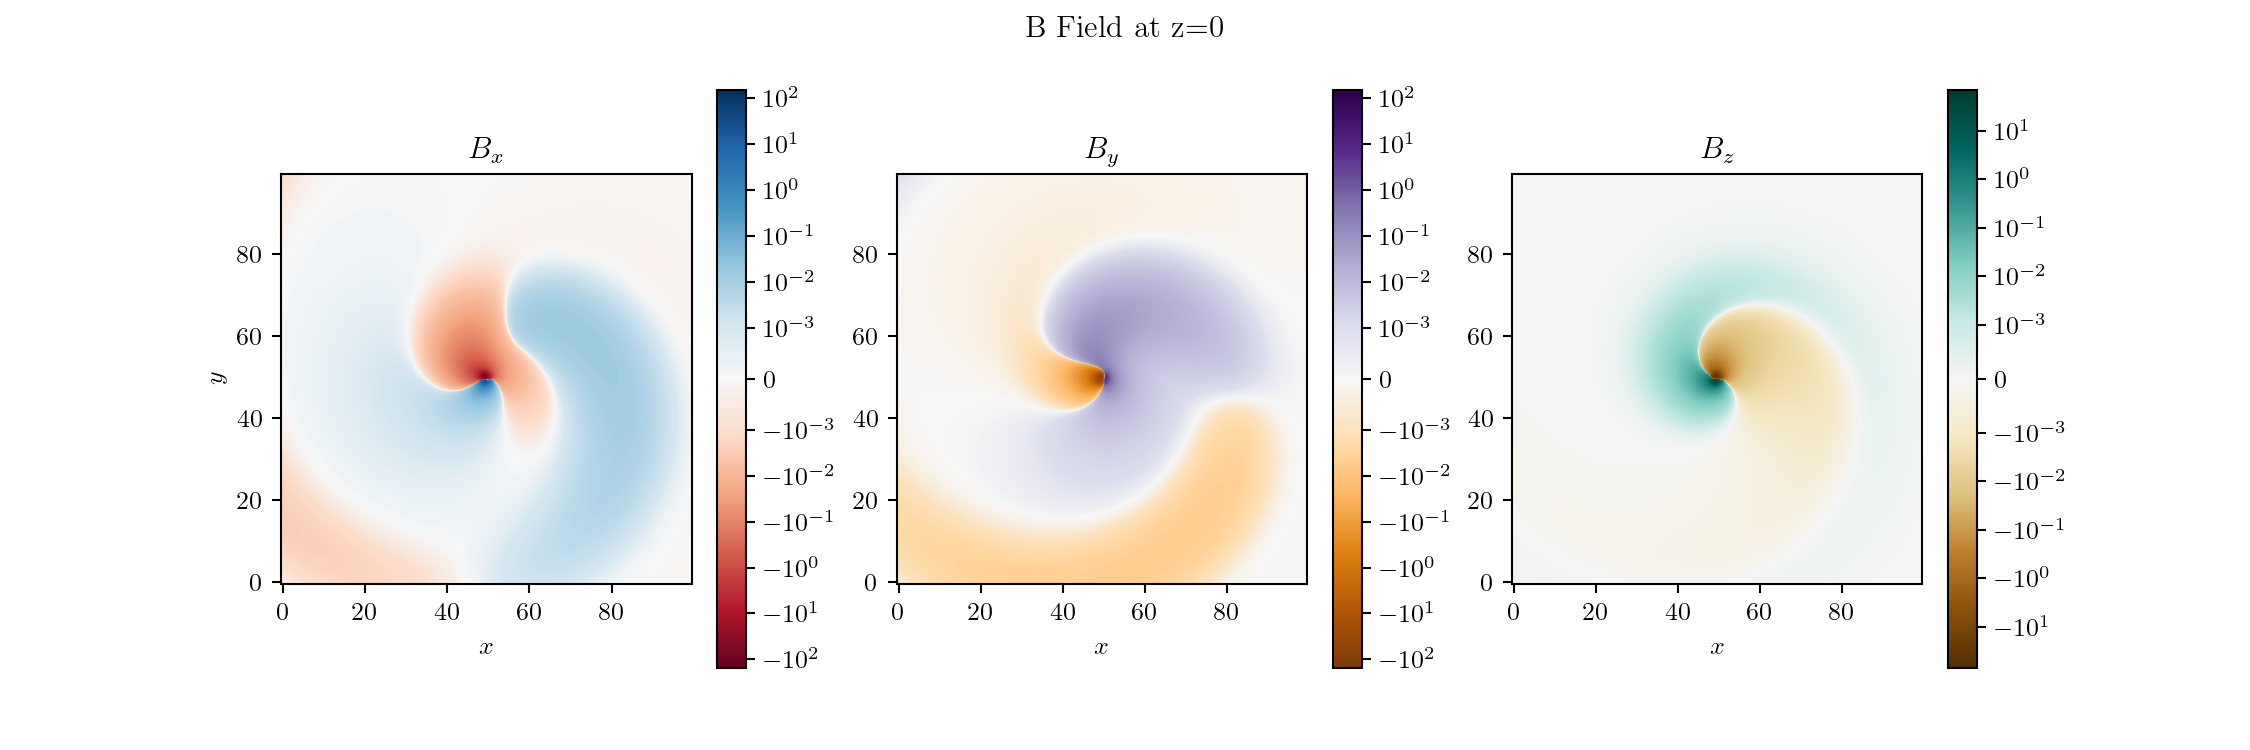

MovieWriter ffmpeg unavailable; using Pillow instead.


In [25]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 150})
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(4)
fig.suptitle('B Field at z=0')
normxy = colors.SymLogNorm(linthresh=1e-3, vmin=-150, vmax=150, base=10)
normz = colors.SymLogNorm(linthresh=1e-3, vmin=-70, vmax=70, base=10)
smx = plt.cm.ScalarMappable(cmap="RdBu", norm=normxy)
smy = plt.cm.ScalarMappable(cmap="PuOr", norm=normxy)
smz = plt.cm.ScalarMappable(cmap="BrBG", norm=normz)

im1 = ax[0].imshow(B_x[0], norm=normxy, interpolation='gaussian', origin='lower', cmap="RdBu")
im2 = ax[1].imshow(B_y[0], norm=normxy, interpolation='gaussian', origin='lower', cmap="PuOr")
im3 = ax[2].imshow(B_z[0], norm=normz, interpolation='gaussian', origin='lower', cmap="BrBG")

fig.colorbar(smx, ax=ax[0])
fig.colorbar(smy, ax=ax[1])
fig.colorbar(smz, ax=ax[2])

ax[0].set_title(r'$B_x$')
ax[1].set_title(r'$B_y$')
ax[2].set_title(r'$B_z$')
ax[0].set_xlabel(r'$x$')
ax[1].set_xlabel(r'$x$')
ax[2].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')

def animate(i) :
    im1.set_data(B_x[i])
    im2.set_data(B_y[i])
    im3.set_data(B_z[i])
    
ani = animation.FuncAnimation(fig, animate, 200, interval=50, repeat=True)
ani.save('synchrotron_rest_frame_B_xy.gif')

plt.show()

### *Skip below for just plotting*
#### Now for x = 0

In [20]:
# Evaluate fields at z=0 to simplify expression
E0 = E.evalf(subs={S[2]: z, S[0]: 0, S[1]: y})
B0 = B.evalf(subs={S[2]: z, S[0]: 0, S[1]: y})

In [21]:
# Split into components
Ex = E0.dot(S.x)
Ey = E0.dot(S.y)
Ez = E0.dot(S.z)

Bx = B0.dot(S.x)
By = B0.dot(S.y)
Bz = B0.dot(S.z)

In [22]:
# Turn into NumPy functions
lam_Ex = lambdify([t, y, z], Ex, "numpy")
lam_Ey = lambdify([t, y, z], Ey, "numpy")
lam_Ez = lambdify([t, y, z], Ez, "numpy")

lam_Bx = lambdify([t, y, z], Bx, "numpy")
lam_By = lambdify([t, y, z], By, "numpy")
lam_Bz = lambdify([t, y, z], Bz, "numpy")

In [23]:
# Create list of timesteps and points in space
tau = np.linspace(0, 100, nsteps)
ngrids = 100
Y, Z = np.meshgrid(np.linspace(-10, 10, ngrids), np.linspace(-10, 10, ngrids))

y_pts = Y.flatten()
z_pts = Z.flatten()
rho_pts = np.sqrt(y_pts**2 + z_pts**2)

In [24]:
# Create data cubes to store slices at each timestep
E_x = np.ndarray((nsteps, ngrids, ngrids))
E_y = np.ndarray((nsteps, ngrids, ngrids))
E_z = np.ndarray((nsteps, ngrids, ngrids))

B_x = np.ndarray((nsteps, ngrids, ngrids))
B_y = np.ndarray((nsteps, ngrids, ngrids))
B_z = np.ndarray((nsteps, ngrids, ngrids))

In [25]:
# Evaluate for all points of the data cube
for i, grid in enumerate(E_z):
    
    E_x[i] = lam_Ex(tau[i]-rho_pts, y_pts, z_pts).reshape(ngrids, ngrids)
    E_y[i] = lam_Ey(tau[i]-rho_pts, y_pts, z_pts).reshape(ngrids, ngrids)
    E_z[i] = lam_Ez(tau[i]-rho_pts, y_pts, z_pts).reshape(ngrids, ngrids)
    
    B_x[i] = lam_Bx(tau[i]-rho_pts, y_pts, z_pts).reshape(ngrids, ngrids)
    B_y[i] = lam_By(tau[i]-rho_pts, y_pts, z_pts).reshape(ngrids, ngrids)
    B_z[i] = lam_Bz(tau[i]-rho_pts, y_pts, z_pts).reshape(ngrids, ngrids)

# Save files for easier access next time
np.save('E_x_yz.npy', E_x)
np.save('E_y_yz.npy', E_y)
np.save('E_z_yz.npy', E_z)
np.save('B_x_yz.npy', B_x)
np.save('B_y_yz.npy', B_y)
np.save('B_z_yz.npy', B_z)

### *Start at this cell for just plotting*

In [2]:
E_x = np.load('E_x_yz.npy')
E_y = np.load('E_y_yz.npy')
E_z = np.load('E_z_yz.npy')
B_x = np.load('B_x_yz.npy')
B_y = np.load('B_y_yz.npy')
B_z = np.load('B_z_yz.npy')

#### Plotting E field components for x = 0

<IPython.core.display.Javascript object>


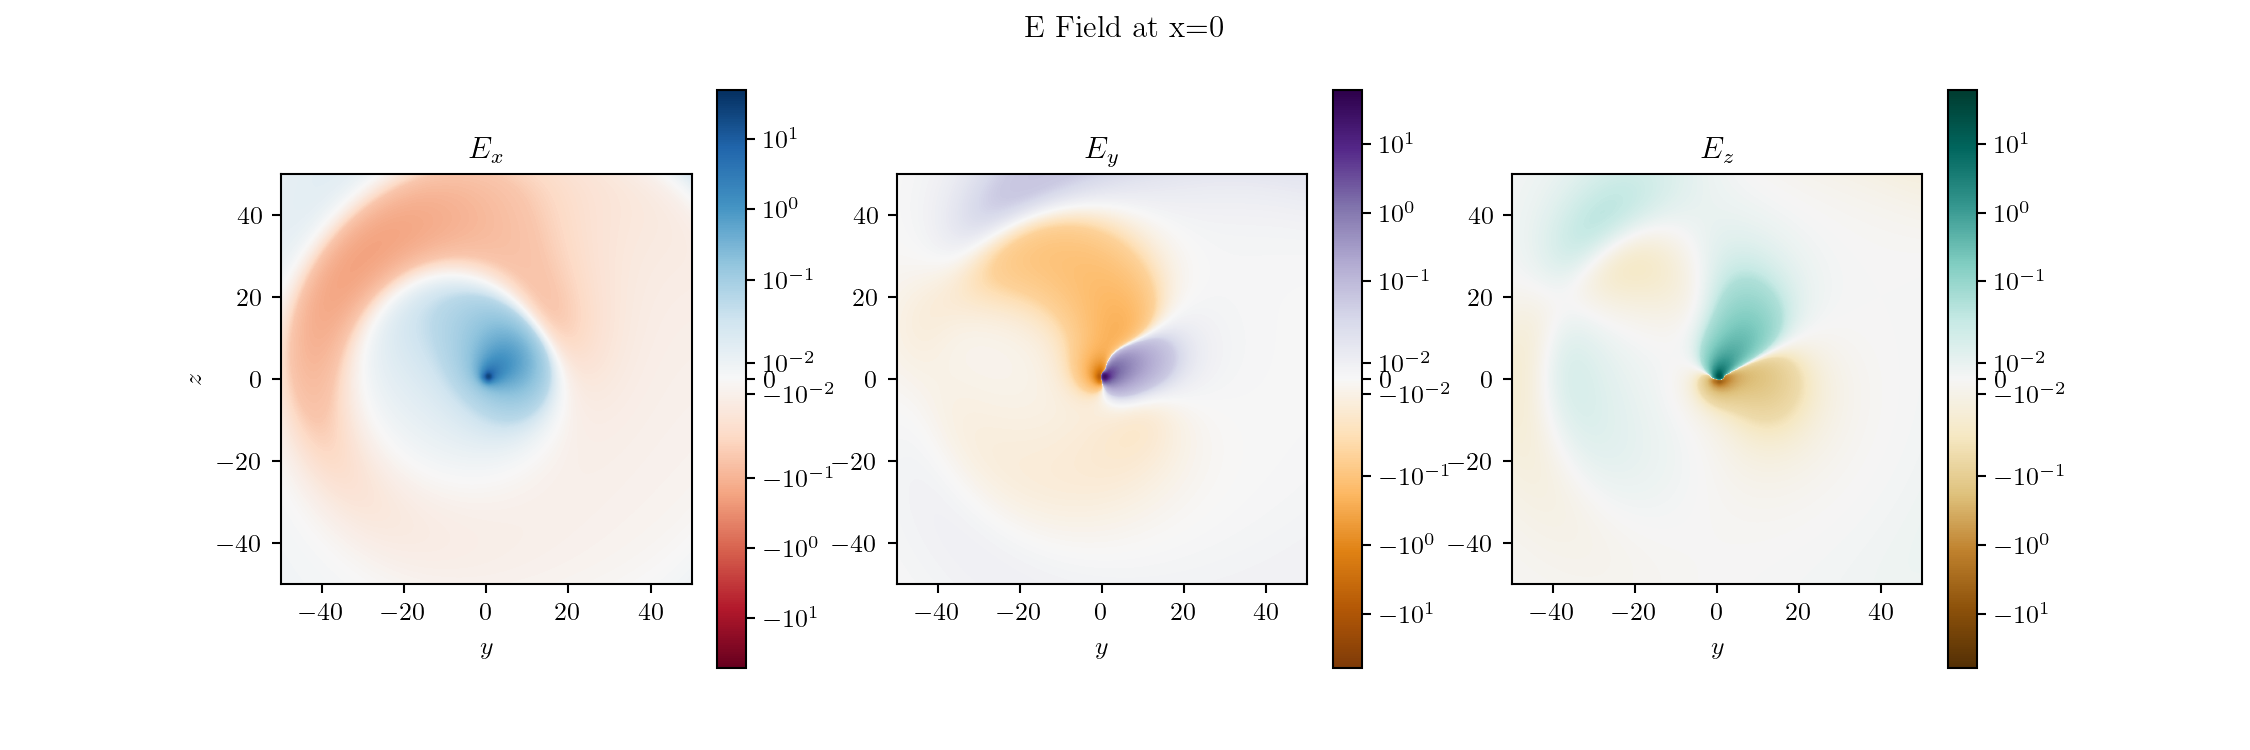

MovieWriter ffmpeg unavailable; using Pillow instead.


In [4]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 150})
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(4)
fig.suptitle('E Field at x=0')
normx = colors.SymLogNorm(linthresh=5e-2, vmin=-50, vmax=50, base=10)
normyz = colors.SymLogNorm(linthresh=5e-2, vmin=-60, vmax=60, base=10)
smx = plt.cm.ScalarMappable(cmap="RdBu", norm=normx)
smy = plt.cm.ScalarMappable(cmap="PuOr", norm=normyz)
smz = plt.cm.ScalarMappable(cmap="BrBG", norm=normyz)

im1 = ax[0].imshow(E_x[0], norm=normx, interpolation='gaussian', origin='lower', cmap="RdBu",
                   extent=[-E_x[0].shape[1]/2., E_x[0].shape[1]/2., -E_x[0].shape[0]/2., E_x[0].shape[0]/2. ])
im2 = ax[1].imshow(E_y[0], norm=normyz, interpolation='gaussian', origin='lower', cmap="PuOr",
                   extent=[-E_y[0].shape[1]/2., E_y[0].shape[1]/2., -E_y[0].shape[0]/2., E_y[0].shape[0]/2. ])
im3 = ax[2].imshow(E_z[0], norm=normyz, interpolation='gaussian', origin='lower', cmap="BrBG",
                   extent=[-E_z[0].shape[1]/2., E_z[0].shape[1]/2., -E_z[0].shape[0]/2., E_z[0].shape[0]/2. ])

fig.colorbar(smx, ax=ax[0])
fig.colorbar(smy, ax=ax[1])
fig.colorbar(smz, ax=ax[2])

ax[0].set_title(r'$E_x$')
ax[1].set_title(r'$E_y$')
ax[2].set_title(r'$E_z$')
ax[0].set_xlabel(r'$y$')
ax[1].set_xlabel(r'$y$')
ax[2].set_xlabel(r'$y$')
ax[0].set_ylabel(r'$z$')

def animate(i) :
    im1.set_data(E_x[i])
    im2.set_data(E_y[i])
    im3.set_data(E_z[i])
    
ani = animation.FuncAnimation(fig, animate, 200, interval=50, repeat=True)
ani.save('synchrotron_rest_frame_E_yz.gif')

plt.show()

#### Now for B at x = 0

MovieWriter ffmpeg unavailable; using Pillow instead.


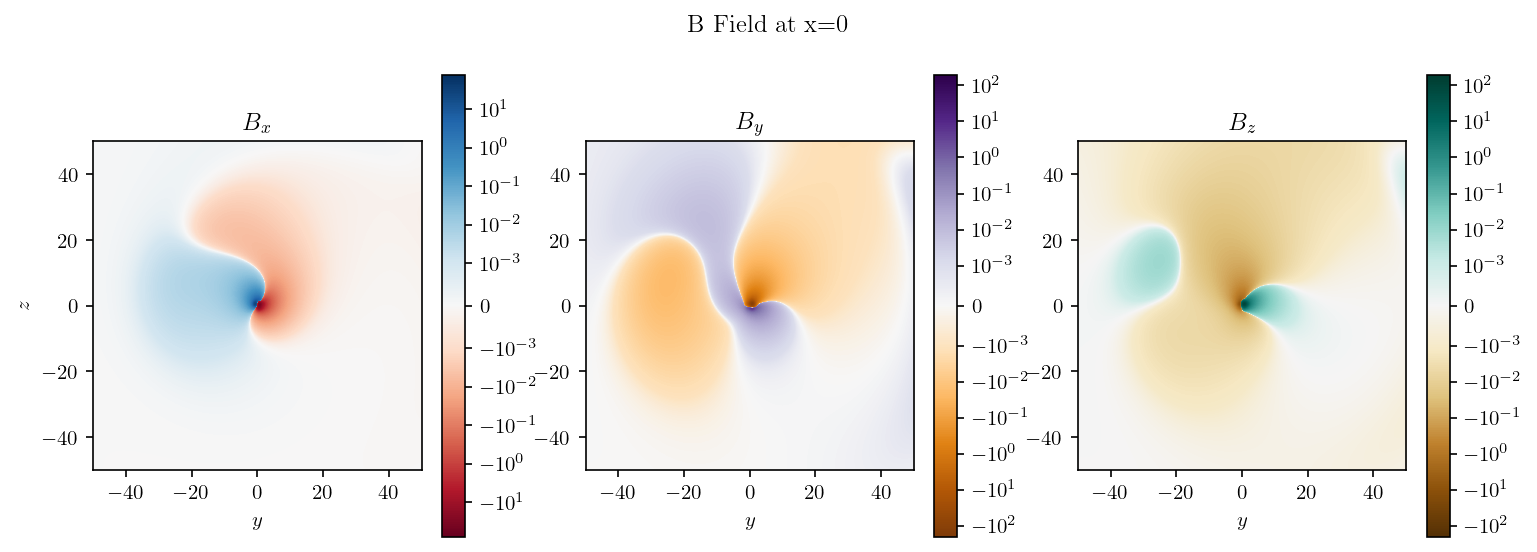

In [11]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 150})
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(4)
fig.suptitle('B Field at x=0')
normx = colors.SymLogNorm(linthresh=1e-3, vmin=-80, vmax=80, base=10)
normyz = colors.SymLogNorm(linthresh=1e-3, vmin=-200, vmax=200, base=10)
smx = plt.cm.ScalarMappable(cmap="RdBu", norm=normx)
smy = plt.cm.ScalarMappable(cmap="PuOr", norm=normyz)
smz = plt.cm.ScalarMappable(cmap="BrBG", norm=normyz)

im1 = ax[0].imshow(B_x[0], norm=normx, interpolation='gaussian', origin='lower', cmap="RdBu",
                   extent=[-B_x[0].shape[1]/2., B_x[0].shape[1]/2., -B_x[0].shape[0]/2., B_x[0].shape[0]/2. ])
im2 = ax[1].imshow(B_y[0], norm=normyz, interpolation='gaussian', origin='lower', cmap="PuOr",
                   extent=[-B_y[0].shape[1]/2., B_y[0].shape[1]/2., -B_y[0].shape[0]/2., B_y[0].shape[0]/2. ])
im3 = ax[2].imshow(B_z[0], norm=normyz, interpolation='gaussian', origin='lower', cmap="BrBG",
                   extent=[-B_z[0].shape[1]/2., B_z[0].shape[1]/2., -B_z[0].shape[0]/2., B_z[0].shape[0]/2. ])

fig.colorbar(smx, ax=ax[0])
fig.colorbar(smy, ax=ax[1])
fig.colorbar(smz, ax=ax[2])

ax[0].set_title(r'$B_x$')
ax[1].set_title(r'$B_y$')
ax[2].set_title(r'$B_z$')
ax[0].set_xlabel(r'$y$')
ax[1].set_xlabel(r'$y$')
ax[2].set_xlabel(r'$y$')
ax[0].set_ylabel(r'$z$')

def animate(i) :
    im1.set_data(B_x[i])
    im2.set_data(B_y[i])
    im3.set_data(B_z[i])
    
ani = animation.FuncAnimation(fig, animate, 200, interval=50, repeat=True)
ani.save('synchrotron_rest_frame_B_yz.gif')

plt.show()